In [16]:
import matplotlib
%matplotlib inline

In [93]:
import sys

sys.path.append("../image")
import krige

sys.path.append("../radar")
import pyart_utils as pu

In [19]:
import pandas as pd

In [20]:
import glob
def process_light_csv(fname):
    df = pd.read_csv(fname)
    df["timestamp"] = pd.to_datetime(fname.split("/")[-1].split(".")[-2])
    return df
light_levels_files = glob.glob("../image/kriged/2017-10-01/*.csv")
light_levels = pd.concat((process_light_csv(f) for f in light_levels_files), ignore_index=True)

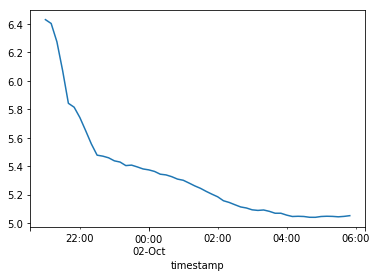

In [21]:
light_levels.groupby("timestamp").z.mean().plot()

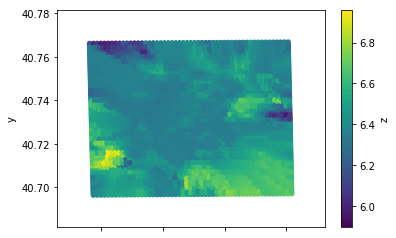

In [26]:
light_levels.sort_values("timestamp").groupby("timestamp")\
.get_group("2017-10-01 21:00:00").plot('x', 'y', c='z', kind='scatter', cmap='viridis')

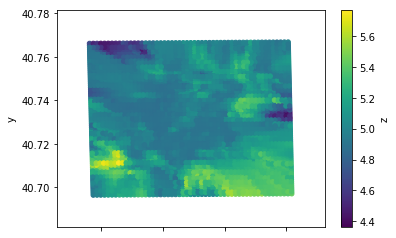

In [27]:
light_levels.sort_values("timestamp").groupby("timestamp")\
.get_group("2017-10-02 04:00:00").plot('x', 'y', c='z', kind='scatter', cmap='viridis')

In [29]:
radar_levels = pd.read_csv("../radar/data/2017-10/01/KOKX20171001_000015_V06.ar2v.filtered.csv")
radar_levels.head()

,Unnamed: 0,dbzh,lon,lat,xx,yy
0,0,2.071455,-74.022494,40.696417,-97671.563582,-18158.887314
1,1,0.159812,-74.021283,40.696429,-97569.452459,-18158.887314
2,2,0.000000,-74.020072,40.696441,-97467.341335,-18158.887314
3,3,0.000000,-74.018861,40.696453,-97365.230212,-18158.887314
4,4,0.000000,-74.017650,40.696465,-97263.119088,-18158.887314


In [65]:
light_levels.head()

,Unnamed: 0,x,y,z,timestamp
0,0,-74.022494,40.696417,6.383496,2017-10-01 21:00:00
1,1,-74.021283,40.696429,6.427349,2017-10-01 21:00:00
2,2,-74.020072,40.696441,6.422921,2017-10-01 21:00:00
3,3,-74.018861,40.696453,6.454693,2017-10-01 21:00:00
4,4,-74.017650,40.696465,6.509335,2017-10-01 21:00:00


In [34]:
def process_radar_csv(fname):
    csv_df = pd.read_csv(fname)
    del csv_df["Unnamed: 0"]
    start = fname.index('KOKX')
    csv_df['Date_Time'] = pd.to_datetime(fname[start+4:start+19],format='%Y%m%d_%H%M%S')
    return csv_df

In [50]:
fnames = glob.glob("../radar/data/2017-10/01/*.filtered.csv")\
       + glob.glob("../radar/data/2017-10/02/*.filtered.csv")
radar_levels = pd.concat((process_radar_csv(fname)\
                          for fname in fnames))

t_filt = (radar_levels.Date_Time >= "2017-10-01 21:00") & (radar_levels.Date_Time <= "2017-10-02 06:00")
radar_levels = radar_levels[t_filt]

In [61]:
import numpy as np
light_ixd = light_levels.set_index('timestamp').sort_index()
radar_ixd = radar_levels.set_index('Date_Time').sort_index()
equal_size = radar_ixd[radar_ixd.index != radar_ixd.index[-1]]

In [62]:
equal_size.index.nunique()

54

In [64]:
equal_size.index = light_ixd.index

In [72]:
light_to_join = light_ixd.reset_index()
radar_to_join = equal_size.reset_index()

In [80]:
mgd = light_to_join.merge(radar_to_join, 
                    left_on=["timestamp", "x", "y"],
                    right_on=["timestamp", "lon", "lat"])


(224532, 224532)

In [86]:
np.corrcoef(mgd["dbzh"], mgd["z"])[0,1]

-0.6906346219524988

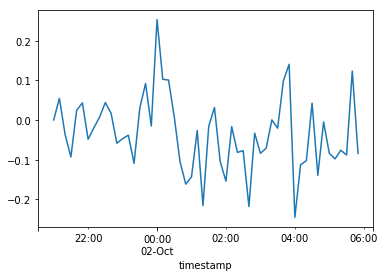

In [88]:
mgd.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot()

In [97]:
mgd.head()

,timestamp,Unnamed: 0,x,y,z,dbzh,lon,lat,xx,yy
0,2017-10-01 21:00:00,0,-74.022494,40.696417,6.383496,0.0,-74.022494,40.696417,-97671.563582,-18158.887314
1,2017-10-01 21:00:00,1,-74.021283,40.696429,6.427349,0.0,-74.021283,40.696429,-97569.452459,-18158.887314
2,2017-10-01 21:00:00,2,-74.020072,40.696441,6.422921,0.0,-74.020072,40.696441,-97467.341335,-18158.887314
3,2017-10-01 21:00:00,3,-74.018861,40.696453,6.454693,0.0,-74.018861,40.696453,-97365.230212,-18158.887314
4,2017-10-01 21:00:00,4,-74.017650,40.696465,6.509335,0.0,-74.017650,40.696465,-97263.119088,-18158.887314


### Now, filter only over manhattan

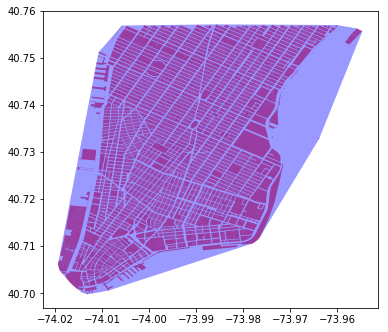

In [94]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline 
fig, ax = plt.subplots(1, 1, figsize=(6, 11))

krige.in_frame.plot(ax=ax, color='red', alpha=.6)
filt = (krige.out_reset.geometry.centroid.x > -74.03) & (krige.out_reset.geometry.centroid.y > 40.7)
krige.out_reset[filt].plot(ax=ax, color='red', alpha=.6)

ch = gpd.GeoSeries(pd.concat([krige.in_frame.geometry, krige.out_reset[filt].geometry])).unary_union.convex_hull
gpd.GeoSeries([ch]).plot(ax=ax, color='blue', alpha=.4)


In [96]:
ch_df = gpd.GeoDataFrame({"geometry": gpd.GeoSeries([ch])})

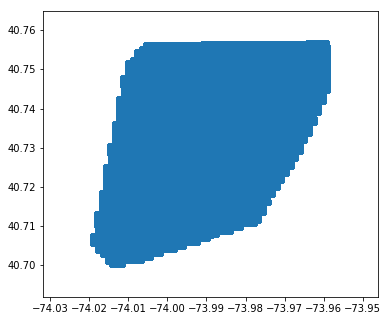

In [98]:
import shapely.geometry
mgd["geometry"] = mgd[["lon", "lat"]].apply(shapely.geometry.Point, axis=1)
mgd = gpd.GeoDataFrame(mgd)
joined = gpd.sjoin(mgd, ch_df)
fig, ax = plt.subplots(1, 1, figsize=(6, 11))
joined.plot(ax=ax)

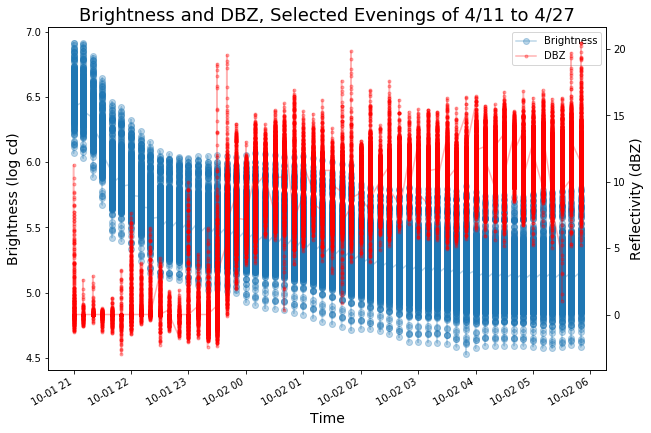

In [103]:
fig = plt.figure(figsize=(10,7),facecolor='w')
ax = fig.add_subplot(111)
df = joined
lns1 = ax.plot(df['timestamp'],df['z'], '-o', label = 'Brightness',alpha=0.3)
ax2 = ax.twinx()
lns3 = ax2.plot(df['timestamp'],df['dbzh'], '-r.', label = 'DBZ',alpha=0.3)


lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


fig.autofmt_xdate()
#ax.grid()
ax.set_title('Brightness and DBZ, Selected Evenings of 4/11 to 4/27',fontsize=18)
#ax.set_xlim('22017-09-30 19:00:33', '2017-10-01 07:51:52')
#ax.set_xlim('2017-04-13 21:00:00', '2017-04-29 05:00:00')


#ax.set_xlim('2017-04-14 21:00:00', '2017-04-15 05:00:00')
#ax.set_xlim('2017-04-18 21:00:00', '2017-04-19 05:00:00')
#ax.set_xlim('2017-04-23 21:00:00', '2017-04-24 05:00:00')
#ax.set_xlim('2017-04-24 21:00:00', '2017-04-25 05:00:00')
#ax.set_xlim('2017-04-27 21:00:00', '2017-04-28 05:00:00')

#ax.set_ylim(0, 0.08)

ax.set_xlabel("Time",fontsize=14)
ax.set_ylabel("Brightness (log cd)",fontsize=14)
ax2.set_ylabel("Reflectivity (dBZ)",fontsize=14)

plt.show()

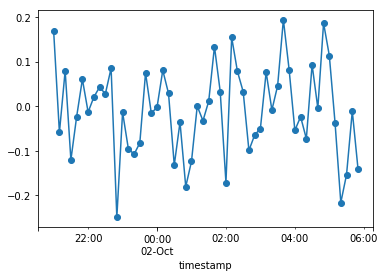

In [105]:
joined.groupby("timestamp").apply(lambda g: np.corrcoef(g["dbzh"], g["z"])[0, 1]).plot(style='-o')